## Import Modules

In [1]:
import numpy as np
import pandas as pd
import json

import scipy
from scipy.spatial.distance import mahalanobis
import scipy.optimize as optimize

from sklearn.linear_model import ElasticNetCV, Lasso

from base_learners.data_loading import load_data, load_from_folder
from visualization.counterfactual_plot import plot_df
from base_learners.base_analysis import get_ate, report_ate, count_coefs, tradeoff

## Check current senario and $T_0$

In [2]:
with open('src/senario_selection.json', 'r') as f:
    json_selection = json.load(f)
    senario = json_selection['senario']
    T0 = json_selection['T0']
    print('We are currently in senario', senario, f'with T0 = {T0}')

We are currently in senario D with T0 = 24


## Load data

In [3]:
control_data, treat_data, untreat_data = load_data(senario)

## Parameters

In [4]:
T = control_data[0].shape[1]  # Total periods
sample_size = len(control_data)  # How many times we draw data
control_units = control_data[0].shape[0]  # How many control units we have

## Prepare for MDD method: matching and optimization

In [5]:
# Matching Difference-in-Difference (MDD): Matching.
# Minimizing the Mahalonobis distance between the treaded and 
# each control unit in the pretreatment period.
distances = np.zeros((sample_size, control_units))
for i in np.arange(sample_size):    
    for j in np.arange(control_units):
        control_unit = control_data[i].values[j][:T0].reshape(1, -1)
        treat_unit = treat_data[i].values[:T0].reshape(1,-1)
        
        # Calculate the inverse of covariance matrix of two vectors.
        df_comb = pd.DataFrame(np.concatenate((control_unit, treat_unit)))
        cov = df_comb.cov()
        try:
            vi = scipy.linalg.inv(cov)
        except:
            print('Singular cov matrix occurs in (dataset, control unit):', (i+1, j))
        
        # Calculate the Mahalonobis distanec.
        md = mahalanobis(control_unit.reshape(-1,), treat_unit.reshape(-1,), vi)
        
        distances[i, j] = md

idx_md_sort = np.argsort(distances, axis=1)
idx_five = idx_md_sort[:, :5]

/srv/conda/envs/notebook/lib/python3.8/site-packages/scipy/spatial/distance.py:1066: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


Singular cov matrix occurs in (dataset, control unit): (5, 3)
Singular cov matrix occurs in (dataset, control unit): (9, 3)
Singular cov matrix occurs in (dataset, control unit): (10, 21)
Singular cov matrix occurs in (dataset, control unit): (13, 19)
Singular cov matrix occurs in (dataset, control unit): (18, 0)
Singular cov matrix occurs in (dataset, control unit): (19, 16)
Singular cov matrix occurs in (dataset, control unit): (21, 14)
Singular cov matrix occurs in (dataset, control unit): (21, 19)
Singular cov matrix occurs in (dataset, control unit): (22, 2)
Singular cov matrix occurs in (dataset, control unit): (26, 22)
Singular cov matrix occurs in (dataset, control unit): (30, 19)
Singular cov matrix occurs in (dataset, control unit): (31, 19)
Singular cov matrix occurs in (dataset, control unit): (33, 8)
Singular cov matrix occurs in (dataset, control unit): (35, 4)
Singular cov matrix occurs in (dataset, control unit): (36, 14)
Singular cov matrix occurs in (dataset, control 

In [6]:
def func_loss(params):
    """
    Used in the loop!
    """
    w, alpha = params
    
    treat = treat_data[i].values[:T0].reshape(-1,)
    
    return np.sum((treat - w * np.sum(control_select.T, axis=1) - alpha * np.ones((T0,))) ** 2)

In [7]:
# MDD: optimazation

# For each iteration, pick up the control unit according to the previous selection.
results = []
initial_guess = [0.2, 1]
for i in np.arange(sample_size):
    control_unit = control_data[i].values[:, :T0]
    idx_select = idx_five[i,:]
    control_select = control_unit[idx_select,:]
    
    # Optimization
    result = optimize.minimize(func_loss, initial_guess)
    results.append(result)

## Get counterfactual predictions for all methods

In [8]:
# Sum-to-one constraint. 
magnitude = 1e5
add = np.ones((control_units, 1)).T * magnitude

# For selecting penalty term using cv: by default we use 5-KFold.
# If there are not enough periods for cv, then use leave-one-out.
if T0 < 5:
    kf = T0
else:
    kf=5

counterfactuals_syn = []
coefs_syn = []

counterfactuals_mdd = []
coefs_mdd = []

counterfactuals_lasso = []
coefs_lasso = []
for i in np.arange(sample_size):
    X = control_data[i].values[:, :T0].T
    y = treat_data[i].values.reshape(-1,)[:T0]
    X_predict = control_data[i].values[:, T0:].T
    
    X_restr = np.concatenate((X, add), axis=0)
    y_restr = np.append(y, magnitude)
    
    # Synthetic Method
    print('{}th iteration: Synthetic Method'.format(i+1))
    regr_syn = Lasso(alpha=0, max_iter=5000, positive=True)
    regr_syn.fit(X_restr, y_restr)
    y_hat_syn = regr_syn.predict(X_predict)
    counterfactuals_syn.append(y_hat_syn)
    coefs_syn.append(regr_syn.coef_)
    
    # MDD Method
    print('{}th iteration: MDD Method'.format(i+1))
    y_hat_mdd = results[i].x[0] * np.sum(X_predict[:, idx_five[i]], axis=1) + results[i].x[1]
    counterfactuals_mdd.append(y_hat_mdd)
    coefs_mdd.append(np.array([results[i].x[0]] * 5))
    
    # Lasso
    print('{}th iteration: Lasso'.format(i+1))
    regr = ElasticNetCV(l1_ratio=1, cv=kf, max_iter=5000)
    regr.fit(X, y)
    y_hat_lasso = regr.predict(X_predict)
    counterfactuals_lasso.append(y_hat_lasso)
    coefs_lasso.append(regr.coef_)
    
# Directly import the imputed data, which has been computed in 02 notebook.
path_mc = 'base_learners/mc_counterfactual/'
mc_imputed = load_from_folder(path_mc)
    
# Extract the last ten elements from the last row:
# this is the values we estimated.
counterfactuals_mc = []
for i in np.arange(len(mc_imputed)):
    mc_est = mc_imputed[i].values[-1, T0:]
    counterfactuals_mc.append(mc_est)

1th iteration: Synthetic Method
1th iteration: MDD Method
1th iteration: Lasso
2th iteration: Synthetic Method
2th iteration: MDD Method
2th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


3th iteration: Synthetic Method
3th iteration: MDD Method
3th iteration: Lasso
4th iteration: Synthetic Method
4th iteration: MDD Method
4th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


5th iteration: Synthetic Method
5th iteration: MDD Method
5th iteration: Lasso
6th iteration: Synthetic Method
6th iteration: MDD Method
6th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: 

7th iteration: Synthetic Method
7th iteration: MDD Method
7th iteration: Lasso
8th iteration: Synthetic Method
8th iteration: MDD Method
8th iteration: Lasso
9th iteration: Synthetic Method
9th iteration: MDD Method
9th iteration: Lasso
10th iteration: Synthetic Method
10th iteration: MDD Method
10th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


11th iteration: Synthetic Method
11th iteration: MDD Method
11th iteration: Lasso
12th iteration: Synthetic Method
12th iteration: MDD Method
12th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


13th iteration: Synthetic Method
13th iteration: MDD Method
13th iteration: Lasso
14th iteration: Synthetic Method
14th iteration: MDD Method
14th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


15th iteration: Synthetic Method
15th iteration: MDD Method
15th iteration: Lasso
16th iteration: Synthetic Method
16th iteration: MDD Method
16th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


17th iteration: Synthetic Method
17th iteration: MDD Method
17th iteration: Lasso
18th iteration: Synthetic Method
18th iteration: MDD Method
18th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


19th iteration: Synthetic Method
19th iteration: MDD Method
19th iteration: Lasso
20th iteration: Synthetic Method
20th iteration: MDD Method
20th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


21th iteration: Synthetic Method
21th iteration: MDD Method
21th iteration: Lasso
22th iteration: Synthetic Method
22th iteration: MDD Method
22th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


23th iteration: Synthetic Method
23th iteration: MDD Method
23th iteration: Lasso
24th iteration: Synthetic Method
24th iteration: MDD Method
24th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


25th iteration: Synthetic Method
25th iteration: MDD Method
25th iteration: Lasso
26th iteration: Synthetic Method
26th iteration: MDD Method
26th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


27th iteration: Synthetic Method
27th iteration: MDD Method
27th iteration: Lasso
28th iteration: Synthetic Method
28th iteration: MDD Method
28th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


29th iteration: Synthetic Method
29th iteration: MDD Method
29th iteration: Lasso
30th iteration: Synthetic Method
30th iteration: MDD Method
30th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


31th iteration: Synthetic Method
31th iteration: MDD Method
31th iteration: Lasso
32th iteration: Synthetic Method
32th iteration: MDD Method
32th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: 

33th iteration: Synthetic Method
33th iteration: MDD Method
33th iteration: Lasso
34th iteration: Synthetic Method
34th iteration: MDD Method
34th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


35th iteration: Synthetic Method
35th iteration: MDD Method
35th iteration: Lasso
36th iteration: Synthetic Method
36th iteration: MDD Method
36th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


37th iteration: Synthetic Method
37th iteration: MDD Method
37th iteration: Lasso
38th iteration: Synthetic Method
38th iteration: MDD Method
38th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


39th iteration: Synthetic Method
39th iteration: MDD Method
39th iteration: Lasso
40th iteration: Synthetic Method
40th iteration: MDD Method
40th iteration: Lasso
41th iteration: Synthetic Method
41th iteration: MDD Method
41th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to us

42th iteration: Synthetic Method
42th iteration: MDD Method
42th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


43th iteration: Synthetic Method
43th iteration: MDD Method
43th iteration: Lasso
44th iteration: Synthetic Method
44th iteration: MDD Method
44th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011261845713113505, tolerance: 0.010163960409639461
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn

45th iteration: Synthetic Method
45th iteration: MDD Method
45th iteration: Lasso
46th iteration: Synthetic Method
46th iteration: MDD Method
46th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


47th iteration: Synthetic Method
47th iteration: MDD Method
47th iteration: Lasso
48th iteration: Synthetic Method
48th iteration: MDD Method
48th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


49th iteration: Synthetic Method
49th iteration: MDD Method
49th iteration: Lasso
50th iteration: Synthetic Method
50th iteration: MDD Method
50th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


51th iteration: Synthetic Method
51th iteration: MDD Method
51th iteration: Lasso
52th iteration: Synthetic Method
52th iteration: MDD Method
52th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010199651864987794, tolerance: 0.009981946760823297
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn

53th iteration: Synthetic Method
53th iteration: MDD Method
53th iteration: Lasso
54th iteration: Synthetic Method
54th iteration: MDD Method
54th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


55th iteration: Synthetic Method
55th iteration: MDD Method
55th iteration: Lasso
56th iteration: Synthetic Method
56th iteration: MDD Method
56th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


57th iteration: Synthetic Method
57th iteration: MDD Method
57th iteration: Lasso
58th iteration: Synthetic Method
58th iteration: MDD Method
58th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


59th iteration: Synthetic Method
59th iteration: MDD Method
59th iteration: Lasso
60th iteration: Synthetic Method
60th iteration: MDD Method
60th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


61th iteration: Synthetic Method
61th iteration: MDD Method
61th iteration: Lasso
62th iteration: Synthetic Method
62th iteration: MDD Method
62th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


63th iteration: Synthetic Method
63th iteration: MDD Method
63th iteration: Lasso
64th iteration: Synthetic Method
64th iteration: MDD Method
64th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


65th iteration: Synthetic Method
65th iteration: MDD Method
65th iteration: Lasso
66th iteration: Synthetic Method
66th iteration: MDD Method
66th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


67th iteration: Synthetic Method
67th iteration: MDD Method
67th iteration: Lasso
68th iteration: Synthetic Method
68th iteration: MDD Method
68th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


69th iteration: Synthetic Method
69th iteration: MDD Method
69th iteration: Lasso
70th iteration: Synthetic Method
70th iteration: MDD Method
70th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


71th iteration: Synthetic Method
71th iteration: MDD Method
71th iteration: Lasso
72th iteration: Synthetic Method
72th iteration: MDD Method
72th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


73th iteration: Synthetic Method
73th iteration: MDD Method
73th iteration: Lasso
74th iteration: Synthetic Method
74th iteration: MDD Method
74th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


75th iteration: Synthetic Method
75th iteration: MDD Method
75th iteration: Lasso
76th iteration: Synthetic Method
76th iteration: MDD Method
76th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


77th iteration: Synthetic Method
77th iteration: MDD Method
77th iteration: Lasso
78th iteration: Synthetic Method
78th iteration: MDD Method
78th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


79th iteration: Synthetic Method
79th iteration: MDD Method
79th iteration: Lasso
80th iteration: Synthetic Method
80th iteration: MDD Method
80th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013907436359494985, tolerance: 0.009642002820766844
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn

81th iteration: Synthetic Method
81th iteration: MDD Method
81th iteration: Lasso
82th iteration: Synthetic Method
82th iteration: MDD Method
82th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


83th iteration: Synthetic Method
83th iteration: MDD Method
83th iteration: Lasso
84th iteration: Synthetic Method
84th iteration: MDD Method
84th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


85th iteration: Synthetic Method
85th iteration: MDD Method
85th iteration: Lasso
86th iteration: Synthetic Method
86th iteration: MDD Method
86th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


87th iteration: Synthetic Method
87th iteration: MDD Method
87th iteration: Lasso
88th iteration: Synthetic Method
88th iteration: MDD Method
88th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


89th iteration: Synthetic Method
89th iteration: MDD Method
89th iteration: Lasso
90th iteration: Synthetic Method
90th iteration: MDD Method
90th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


91th iteration: Synthetic Method
91th iteration: MDD Method
91th iteration: Lasso
92th iteration: Synthetic Method
92th iteration: MDD Method
92th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


93th iteration: Synthetic Method
93th iteration: MDD Method
93th iteration: Lasso
94th iteration: Synthetic Method
94th iteration: MDD Method
94th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


95th iteration: Synthetic Method
95th iteration: MDD Method
95th iteration: Lasso
96th iteration: Synthetic Method
96th iteration: MDD Method
96th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


97th iteration: Synthetic Method
97th iteration: MDD Method
97th iteration: Lasso
98th iteration: Synthetic Method
98th iteration: MDD Method
98th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


99th iteration: Synthetic Method
99th iteration: MDD Method
99th iteration: Lasso
100th iteration: Synthetic Method
100th iteration: MDD Method
100th iteration: Lasso


<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
<ipython-input-8-e43f81e1fb25>:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regr_syn.fit(X_restr, y_restr)
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


## Analysis

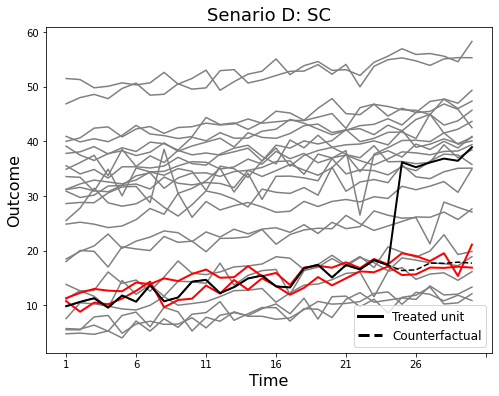

In [9]:
plot_df(control_data[40], f'Senario {senario}: SC', treat_data[40], counterfactuals_syn[40], save_fig=True, case='SC')

In [10]:
ate_hat_syn, ate_syn = get_ate(counterfactuals_syn, control_data, treat_data, untreat_data, T0)
number_control_syn = count_coefs(coefs_syn)
report_ate(ate_hat_syn, number_control_syn)

Mean of ate: 19.982290947855905
Standard deviation of ate: 1.1992305298709836
Sum of average treatment effect: 119.89374568713542
Number of controls with weights above 1%: 1.0


In [11]:
tradeoff(ate_hat_syn, ate_syn, sample_size)

Bias^2:
 [0.01134436 0.00904245 0.01026501 0.02449205 0.00586223 0.00136249]


Variance:
 [1.49661582 1.62231247 1.23547538 1.22919507 1.55499214 1.51564913]


Bias^2 + Variance:
 [1.50796018 1.63135492 1.2457404  1.25368712 1.56085437 1.51701162]


MSE for verification:
 [1.50796018 1.63135492 1.2457404  1.25368712 1.56085437 1.51701162]


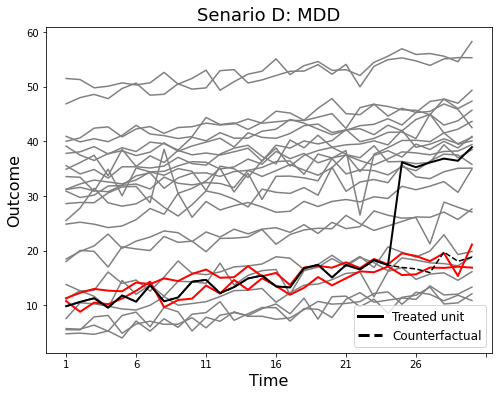

In [12]:
plot_df(control_data[40], f'Senario {senario}: MDD', treat_data[40], counterfactuals_mdd[40], save_fig=True, case='MDD')

In [13]:
ate_hat_mdd, ate_mdd = get_ate(counterfactuals_mdd, control_data, treat_data, untreat_data, T0)
number_control_mdd = count_coefs(coefs_mdd)
report_ate(ate_hat_mdd, number_control_mdd)

Mean of ate: 20.223883127858382
Standard deviation of ate: 1.6174693723106355
Sum of average treatment effect: 121.34329876715029
Number of controls with weights above 1%: 5.0


In [14]:
tradeoff(ate_hat_mdd, ate_mdd, sample_size)

Bias^2:
 [1.76906057e-02 1.73064817e-01 9.54924559e-03 7.26217111e-05
 5.63014565e-02 2.18841003e-01]


Variance:
 [2.20821445 2.58784559 1.90226764 3.03002959 3.16718426 2.92597494]


Bias^2 + Variance:
 [2.22590506 2.76091041 1.91181688 3.03010221 3.22348571 3.14481594]


MSE for verification:
 [2.22590506 2.76091041 1.91181688 3.03010221 3.22348571 3.14481594]


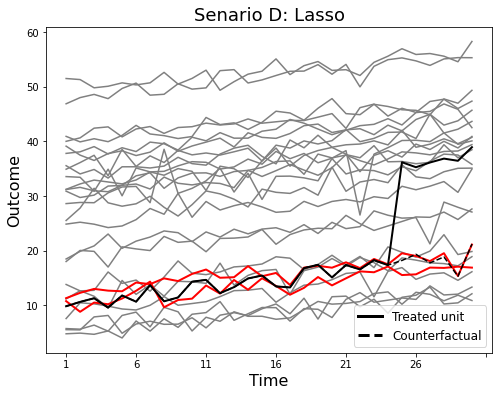

In [15]:
plot_df(control_data[40], f'Senario {senario}: Lasso', treat_data[40], counterfactuals_lasso[40], save_fig=True, case='Lasso')

In [16]:
ate_hat_lasso, ate_lasso = get_ate(counterfactuals_lasso, control_data, treat_data, untreat_data, T0)
number_control_lasso = count_coefs(coefs_lasso)
report_ate(ate_hat_lasso, number_control_lasso)

Mean of ate: 20.19666317118438
Standard deviation of ate: 1.3375621628847696
Sum of average treatment effect: 121.17997902710627
Number of controls with weights above 1%: 5.86


In [17]:
tradeoff(ate_hat_lasso, ate_lasso, sample_size)

Bias^2:
 [0.00070681 0.08166821 0.03149673 0.02225104 0.07105575 0.1073116 ]


Variance:
 [1.20829544 2.14324512 1.60883321 1.66614373 1.95014138 2.2695453 ]


Bias^2 + Variance:
 [1.20900225 2.22491334 1.64032994 1.68839476 2.02119713 2.3768569 ]


MSE for verification:
 [1.20900225 2.22491334 1.64032994 1.68839476 2.02119713 2.3768569 ]


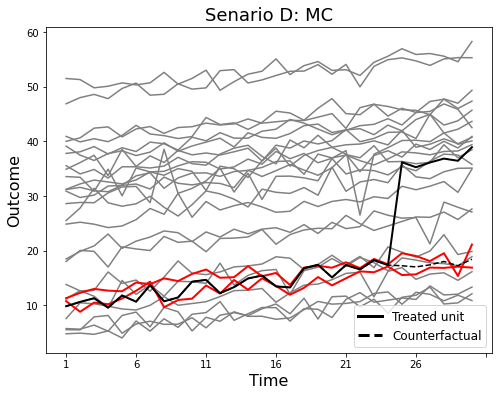

In [18]:
plot_df(control_data[40], f'Senario {senario}: MC', treat_data[40], counterfactuals_mc[40], save_fig=True, case='MC')

In [19]:
ate_hat_mc, ate_mc = get_ate(counterfactuals_mc, control_data, treat_data, untreat_data, T0)
report_ate(ate_hat_mc, control_idx_list=None)

Mean of ate: 20.019896283972436
Standard deviation of ate: 1.3864932683626376
Sum of average treatment effect: 120.11937770383462
No available weights for reporting!


In [20]:
tradeoff(ate_hat_mc, ate_mc, sample_size)

Bias^2:
 [0.00242623 0.03881547 0.00042577 0.03023326 0.00017013 0.02343535]


Variance:
 [1.34789563 2.0108772  1.98753039 2.24865216 2.22820708 1.78984223]


Bias^2 + Variance:
 [1.35032186 2.04969267 1.98795616 2.27888542 2.2283772  1.81327758]


MSE for verification:
 [1.35032186 2.04969267 1.98795616 2.27888542 2.2283772  1.81327758]


## Store some variables for usage in notebook 05 and 06

In [21]:
%%capture
%store T
%store senario
%store T0
%store add
%store kf
%store control_units
%store sample_size
%store control_data
%store treat_data
%store untreat_data
%store initial_guess
%store magnitude
%store counterfactuals_syn
%store counterfactuals_mdd
%store counterfactuals_lasso
%store counterfactuals_mc

%store ate_hat_syn
%store ate_syn
%store ate_hat_lasso
%store ate_lasso
%store ate_hat_mdd
%store ate_mdd
%store ate_hat_mc
%store ate_mc

Click here to go to [04 Matrix completion with cross-validation](04%20Matrix%20completion%20with%20cross-validation.ipynb)